In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math
import csv
import os

In [12]:
# Condition constants
rho_l = 1.0  # Left boundary density
# u_l = 0  # Left boundary gas velocity (along x)
p_l = 1.0e5  # Left boundary pressure
E = 1.0e6  # Left boundary kinetic energy

rho_r = 1.0  # Right boundary density
u_r = 0  # Right boundary gas velocity (along x)
p_r = 1.0e5  # Right boundary pressure

# Main part of the program
X = 2000.0  # Coordinate boundary [meters]
center = X / 2  # Center [meters]
T = 1.50  # Time [seconds]

Pmax = 1.5e5  # Critical pressure

nx = 2000  # Number of steps on dimension coordinate
gamma = 1.4  # Polytropic index
cu = 0.99  # Courant number

dx = X / nx  # Coordinate step

In [13]:
# Condition functions
def explosive_charge(t, le):
    u_l = math.sqrt(2 * E / (rho_l * le))
    return [rho_l, rho_l * u_l, p_l / (gamma - 1) + 0.5 * rho_l * u_l**2]

def boundary_condition(t):
    return [rho_r, rho_r * u_r, p_r / (gamma - 1) + 0.5 * rho_r * u_r**2]

def initial_condition(i, center, le):
    if center - le <= (i - 1) * dx <= center + le:
        return explosive_charge(0, le)
    else:
        return boundary_condition(0)

In [14]:
# Calculating functions
def eigenvalue(q):
    rho = q[0]
    u = q[1] / q[0]
    etot = q[2]
    eint = etot - 0.5 * rho * u**2
    p = eint * (gamma - 1)
    c = np.sqrt(gamma * p / rho)
    return [u - c, u, u + c]

def f(q):
    rho = q[0]
    u = q[1] / q[0]
    etot = q[2]
    eint = etot - 0.5 * rho * u**2
    p = eint * (gamma - 1)
    return np.array([q[1], rho * u**2 + p, (etot + p) * u])

def hll(q, dt):
    leigenvalues = eigenvalue(q[:, 0])
    reigenvalues = eigenvalue(q[:, 1])
    S_l = np.min(np.concatenate((leigenvalues, reigenvalues)))
    S_r = np.max(np.concatenate((leigenvalues, reigenvalues)))

    if S_r < 0:
        return f(q[:, 1])
    elif S_l > 0:
        return f(q[:, 0])
    else:
        qhll = (f(q[:, 0]) - f(q[:, 1]) + q[:, 1] * S_r - q[:, 0] * S_l) / (S_r - S_l)
        fhll = f(q[:, 1]) + S_r * (qhll - q[:, 1])
        return fhll

def calculate_cell(q, f_function, dt):
    return q[:, 1] - dt / dx * (f_function(q[:, 1:3], dt) - f_function(q[:, 0:2], dt))

In [15]:
def calculate_length(row_p, Pmax):
    lengths = 0
    for p in row_p:
        if p > Pmax:
            lengths += X/nx
    return lengths

In [32]:
def solver(le):
    # Load data from CSV file
    output_dir = f"output/le_{le}"
    os.makedirs(output_dir, exist_ok=True)

    csv_rho = open(os.path.join(output_dir, "rho.csv"), "w", newline="")
    csv_u = open(os.path.join(output_dir, "u.csv"), "w", newline="")
    csv_etot = open(os.path.join(output_dir, "etot.csv"), "w", newline="")
    csv_p = open(os.path.join(output_dir, "p.csv"), "w", newline="")

    writer_rho = csv.writer(csv_rho)
    writer_u = csv.writer(csv_u)
    writer_etot = csv.writer(csv_etot)
    writer_p = csv.writer(csv_p)

    headers = ["time"] + [f"x_{i}" for i in range(nx)]

    writer_rho.writerow(headers)
    writer_u.writerow(headers)
    writer_etot.writerow(headers)
    writer_p.writerow(headers)

    # Creating a 2-dimension calculation field
    Q0 = np.empty((3, nx))

    # Maximum length where P > Pmax
    max_length = 0

    # Iteration counter
    iter_count = 0

    for i in range(nx):
        Q0[:, i] = initial_condition(i, center, le)

    # Main simulation loop
    t = 0
    while t < T:
        iter_count += 1
        if iter_count > 1000:
            break

        row_rho = np.array(Q0[0, :])
        row_u = np.array(Q0[1, :]) / row_rho
        row_etot = np.array(Q0[2, :])
        row_p = ((np.array(Q0[2, :]) - 0.5 * np.array(Q0[1, :])**2 / np.array(Q0[0, :])) * (gamma - 1))

        writer_rho.writerow(np.insert(row_rho, 0, t))
        writer_u.writerow(np.insert(row_u, 0, t))
        writer_etot.writerow(np.insert(row_etot, 0, t))
        writer_p.writerow(np.insert(row_p, 0, t))

        # Calculating the length above Pmax
        # print(np.max(row_p))
        total_length = calculate_length(row_p, Pmax)
        # print(total_length)
        
        if total_length > max_length:
            max_length = total_length

        # Finding the time step
        lambda_val = float(np.abs(Q0[1, 0] / Q0[0, 0]))
        for i in range(nx):
            eigenvalues = eigenvalue(Q0[:, i])
            lambda_val = float(np.maximum(np.max(np.abs(eigenvalues)), lambda_val))

        dt = cu * dx / lambda_val

        t += dt

        # Creating the next time layer
        Q1 = np.empty_like(Q0)
        Q1[:, 0] = boundary_condition(t)
        Q1[:, -1] = boundary_condition(t)
        for i in range(1, nx - 1):
            Q1[:, i] = calculate_cell(Q0[:, i-1:i+2], hll, dt)

        Q0 = np.copy(Q1)

    csv_rho.close()
    csv_u.close()
    csv_etot.close()
    csv_p.close()

    return max_length

In [33]:
striking_area = {}

# for le in np.arange(30.0, 40.0, 1.0):
#     print(f"le = {le}")
#     striking_area[le] = solver(le)

le = 39.0
striking_area[le] = solver(le)

print(striking_area)

{39.0: 60.0}


In [34]:
# print striking_area 
for le, area in striking_area.items():
    print(f"le = {le}, area = {area}")

le = 39.0, area = 60.0


In [35]:
# shutil.rmtree(plots_dir)

In [36]:
# Load data from CSV file
def load_data(file_path):
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)
        data = np.array([row for row in reader], dtype=float)
    
    return headers, data

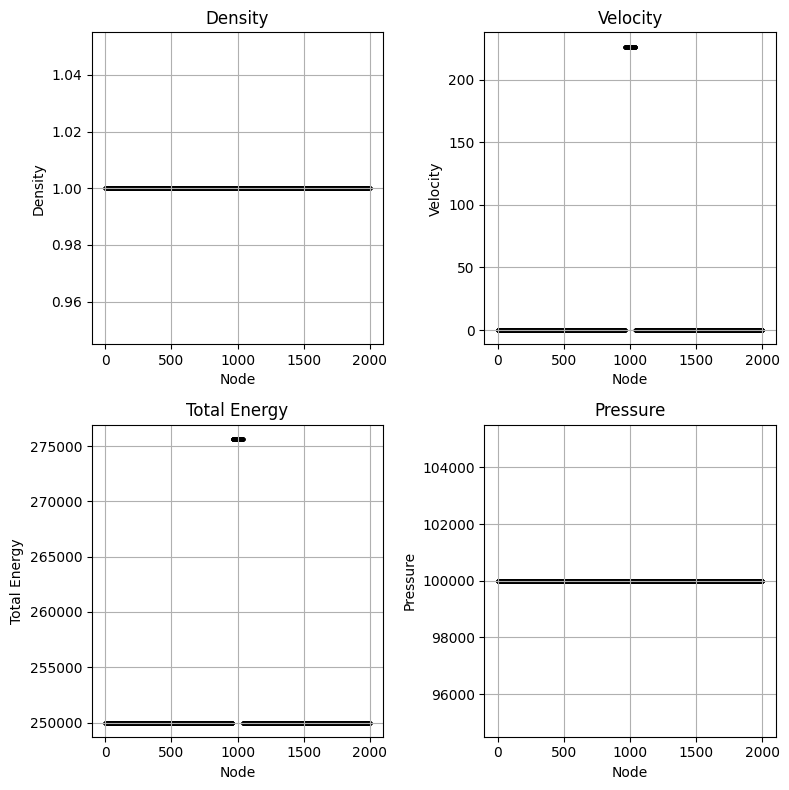

In [38]:
# Make directory for output
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

le = 39.0
file_dir = f"output/le_{le}/"
# Load data
selected_file_path = file_dir + "rho.csv"
headers_time, data_time = load_data(selected_file_path)
headers_rho, data_rho = load_data(selected_file_path)

selected_file_path = file_dir +"u.csv"
headers_u, data_u = load_data(selected_file_path)

selected_file_path = file_dir + "etot.csv"
headers_etot, data_etot = load_data(selected_file_path)

selected_file_path = file_dir + "p.csv"
headers_p, data_p = load_data(selected_file_path)

# N = 5

# data_time = data_time[::N, :]
# data_rho = data_rho[::N, :]
# data_u = data_u[::N, :]
# data_etot = data_etot[::N, :]
# data_p = data_p[::N, :]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

stride = 10

def update(frame):
    if frame % stride == 0:
        axs[0, 0].clear()
        axs[0, 1].clear()
        axs[1, 0].clear()
        axs[1, 1].clear()

        selected_time = data_time[frame, 0]

        x = [dx * i for i in range(nx)]

        axs[0, 0].scatter(x, data_rho[frame, 1:], c='black', marker='o', s=4)
        axs[0, 0].set_title('Density')
        axs[0, 0].set_xlabel('Node')
        axs[0, 0].set_ylabel('Density')
        axs[0, 0].grid()

        axs[0, 1].scatter(x, data_u[frame, 1:], c='black', marker='o', s=4)
        axs[0, 1].set_title('Velocity')
        axs[0, 1].set_xlabel('Node')
        axs[0, 1].set_ylabel('Velocity')
        axs[0, 1].grid()

        axs[1, 0].scatter(x, data_etot[frame, 1:], c='black', marker='o', s=4)
        axs[1, 0].set_title('Total Energy')
        axs[1, 0].set_xlabel('Node')
        axs[1, 0].set_ylabel('Total Energy')
        axs[1, 0].grid()

        axs[1, 1].scatter(x, data_p[frame, 1:], c='black', marker='o', s=4)
        axs[1, 1].set_title('Pressure')
        axs[1, 1].set_xlabel('Node')
        axs[1, 1].set_ylabel('Pressure')
        axs[1, 1].grid()

        plt.tight_layout()

        plt.savefig(os.path.join(plots_dir, f'frame_{frame:03d}.png'))

# Make animation
ani = animation.FuncAnimation(fig, update, frames=len(data_time), repeat=False)

# Save GIF
ani.save('animation.gif', writer='pillow', fps=20)

# # Clean up output dir
# shutil.rmtree(output_dir)



le = 20.0, area = 32.0 \
le = 25.0, area = 40.0 \
le = 30.0, area = 47.0 \
le = 31.0, area = 49.0 \
le = 32.0, area = 50.0 \
le = 33.0, area = 52.0 \
le = 34.0, area = 53.0 \
le = 35.0, area = 54.0 \
le = 36.0, area = 56.0 \
le = 37.0, area = 57.0 \
le = 38.0, area = 59.0 \
le = 39.0, area = 60.0 \
le = 40.0, area = 33.0 \
le = 45.0, area = 0 \
le = 50.0, area = 0